## ANALISIS EXPLORATORIO DE LOS DATOS.

Diccionario de datos:

* **step**: este campo es una unidad de tiempo en el mundo real. En este caso, un paso es 1 hora de tiempo. El total de pasos es 744 (31 días).
* **type**: ingreso de dinero (CASH_IN), retirada de dinero (CASH_OUT), tarjeta de débito (DEBIT), pago (PAYMENT) y transferencia (TRANSFER).
* **amount**: cantidad de la transacción en moneda local.
* **nameOrig**: cliente que inició la transacción.
* **oldbalanceOrg**: saldo del cliente antes de la transacción.
* **newbalanceOrig**: saldo del cliente después de la transacción.
* **nameDest**: destinatario de la transacción.
* **oldbalanceDest**: saldo inicial del destinatario antes de la transacción. Hay que tener en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).
* **newbalanceDest**: saldo del destinatario después de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).
* **isFraud**: son las transacciones realizadas por agentes fraudulentos dentro de la simulación. En este conjunto de datos en particular, el comportamiento fraudulento de los agentes tiene como objetivo obtener ganancias al tomar el control de las cuentas de los clientes e intentar vaciar los fondos transfiriéndolos a otra cuenta y luego retirándolos del sistema.
* **isFlaggedFraud**: el modelo de negocio tiene como objetivo controlar las transferencias masivas de una cuenta a otra y marcar los intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200.000 de una sola vez.

In [1]:
import math

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan

plt.rcParams['figure.figsize'] = (15, 15)

if not (("sc" in globals()) or ("sc" in locals())):
    conf=SparkConf()
    conf.set("spark.driver.memory", "16g")
    sc = SparkContext.getOrCreate(conf)
spark = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/22 19:00:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.\
    read.\
    parquet("fraud2.parquet")

df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)



La variable que queremos predecir es `isFraud` y el resto de variables caracterizan las transacciones.

In [4]:
df.summary().toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
step,6362620,243.39724563151657,142.3319710491244,1,156,239,335,743
type,6362620,None,None,CASH_IN,None,None,None,TRANSFER
amount,6362620,179861.90354912292,603858.2314629285,0.0,13383.63,74864.38,208720.6,9.244551664E7
nameOrig,6362620,None,None,C1000000639,None,None,None,C999999784
oldbalanceOrg,6362620,833883.1040744851,2888242.6730375285,0.0,0.0,14216.6,107288.0,5.958504037E7
newbalanceOrig,6362620,855113.6685785672,2924048.5029542595,0.0,0.0,0.0,144212.66,4.958504037E7
nameDest,6362620,None,None,C1000004082,None,None,None,M999999784
oldbalanceDest,6362620,1100701.6665196999,3399180.1129945437,0.0,0.0,132612.49,942582.7,3.5601588935E8
newbalanceDest,6362620,1224996.3982020712,3674128.9421197013,0.0,0.0,214605.81,1111611.51,3.5617927892E8


Como se puede observar hay más de 6,3 millones de registros. El importe de la transferencia media es de 179.861,9 con una desviación típica de 603.858,2.

In [5]:
df.select("nameOrig").distinct().count()

6353307

In [6]:
df.select("nameDest").distinct().count()

2722362

Se puede observar que hay 6.353.307 clientes distintos haciendo transferencias y 2.722.362 de destinatarios de transferencias.

Para facilitarnos el análisis, vamos a crear una nueva columna que nos va a ayudar durante el analisis de datos, para aquellos clientes que son comerciantes (Es decir, el nombre empieza por "M"). Esta columna no la alimentaremos al modelo en fases posteriores.

In [7]:
df = df.withColumn("isMerchant", when(df.nameDest.startswith("M"), True).otherwise(False))

df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|isMerchant|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|      true|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|      true|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|     false|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|     false|

In [9]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+----------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|isMerchant|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+----------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|         0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+----------+



Podemos observar que no hay valores nulos en el dataset.

In [10]:
def plot_histogram (df, num_bins = 20):
    num_columns = math.floor(math.sqrt(len(df.columns)))
    num_rows = math.ceil(math.sqrt(len(df.columns)))
    i = 1
    for x in df.columns:
        plt.subplot(num_rows, num_columns, i)
        plt.title(x)
        if df.schema[x].dataType.typeName() == "string":
            group_df = df.groupby(x).count()
            x =group_df.select(x).toPandas().values.reshape(-1)
            height =group_df.select("count").toPandas().values.reshape(-1)
            if group_df.count() < num_bins:
                plt.bar(x, height)
        else:
            bins, counts = df.select(x).rdd.flatMap(lambda x: x).histogram(num_bins)
            plt.hist(bins[:-1], bins=bins, weights=counts)
        i += 1

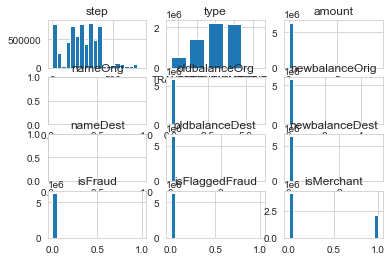

In [11]:
plot_histogram(df)

Aqui ya podemos ver que existe un importante desbalanceo entre las transacciones lícitas y las fraudulentas.

In [12]:
df.groupby("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



Estamos ante un dataset que esta muy desbalanceado. Este hecho habrá que tenerlo en cuenta durante todo el proyecto. Por el momento vamos a estudiar ambas clases por separado.

In [13]:
fraud_df = df.where(df.isFraud == 1)
no_fraud_df = df.where(df.isFraud == 0)

In [14]:
fraud_df.summary().toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
step,8213,368.4138560818215,216.38869034045004,1,181,367,558,743
type,8213,None,None,CASH_OUT,None,None,None,TRANSFER
amount,8213,1467967.299140387,2404252.947240167,0.0,127018.14,440962.56,1517771.48,1.0E7
nameOrig,8213,None,None,C1000036340,None,None,None,C99979309
oldbalanceOrg,8213,1649667.6057116783,3547719.4391091308,0.0,125464.46,438983.45,1517771.48,5.958504037E7
newbalanceOrig,8213,192392.63183611343,1965666.455719133,0.0,0.0,0.0,0.0,4.958504037E7
nameDest,8213,None,None,C1000039615,None,None,None,C999955448
oldbalanceDest,8213,544249.6190746377,3336420.9509249586,0.0,0.0,0.0,147582.41,2.3623051682E8
newbalanceDest,8213,1279707.6171459865,3908816.533815755,0.0,0.0,4555.92,1057953.31,2.3672649466E8


El importe de la transferencia fraudulenta media es de 1.467.967 con una desviación típica de 2.404.252. Podemos ver que hay bastante variabilidad en cuanto al importe de las transferencias fraudulentas.

In [15]:
fraud_df.groupby("type").count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



Respecto al tipo de movimiento, podemos observar que solo hay 2 tipos que son fraudulentos.

In [16]:
fraud_df.select("nameOrig").distinct().count()

8213

In [17]:
fraud_df.select("nameDest").distinct().count()

8169

Asimismo podemos observar que hay 8.213 clientes estafados y 8.169 clientes que estafan.

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


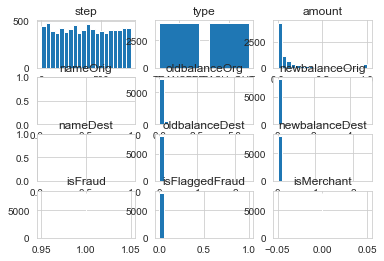

In [18]:
plot_histogram(fraud_df)

Podemos ver que la distribución de la variable `step` es uniforme, por lo que quiere decir que las transacciones fraudulentas ocurren uniformemente a lo largo del tiempo.

Por otro lado, podemos ver que las transacciones fraudulentas son entre cuentas de clientes y no de comerciantes, ya que no hay valores "1" en la columna `isMerchant`.

Los tipos de movimientos donde se producen fraude son en retiradas de efectivo y transferencias. Además, tienen una proporción similar de operaciones fraudulentas.

In [19]:
fraud_df.groupby("isFlaggedFraud").count().show()

+--------------+-----+
|isFlaggedFraud|count|
+--------------+-----+
|             0| 8197|
|             1|   16|
+--------------+-----+



Con respecto a la columna `isFlaggedFraud` tiene pocos registros cuyo valor sea informado frente al grueso de transferencias fraudulentas y, por tanto, va a aportar poco al modelo. Lo mejor sería descartarla.

<AxesSubplot:>

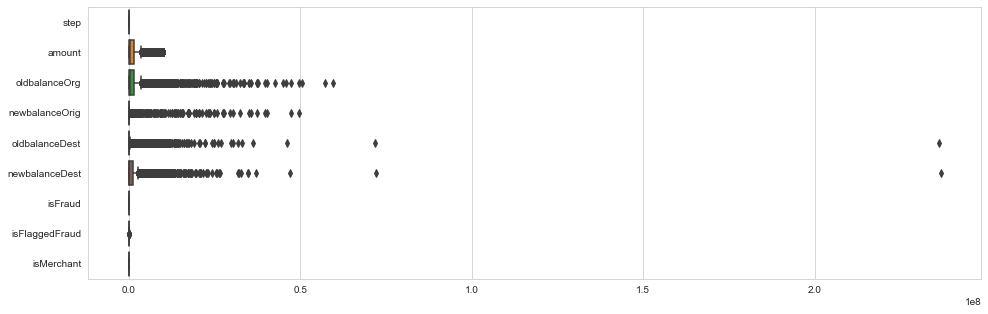

In [20]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=fraud_df.toPandas(), orient="h")

Del boxplot podemos observar que hay muchos outliers en las columnas de importe de transferencias y de balances antes y despues de la transferencia. Sin embargo, son datos que no podemos quitar, ya que son datos relevantes para el modelo que vamos a desarrollar.

In [21]:
no_fraud_df.summary().toPandas().T

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
step,6354407,243.23566306029815,142.1401944921965,1,156,239,334,718
type,6354407,None,None,CASH_IN,None,None,None,TRANSFER
amount,6354407,178197.04172739814,596236.9813472016,0.01,13360.27,74670.06,208340.35,9.244551664E7
nameOrig,6354407,None,None,C1000000639,None,None,None,C999999784
oldbalanceOrg,6354407,832828.7117272562,2887144.0303329905,0.0,0.0,14066.57,106923.0,4.38188553E7
newbalanceOrig,6354407,855970.2281087907,2924986.9646495897,0.0,0.0,0.0,144604.71,4.368661633E7
nameDest,6354407,None,None,C1000004082,None,None,None,M999999784
oldbalanceDest,6354407,1101420.8745694289,3399201.7933785026,0.0,0.0,133146.0,944231.24,3.5601588935E8
newbalanceDest,6354407,1224925.6845633048,3673815.709922623,0.0,0.0,214961.26,1111724.08,3.5617927892E8


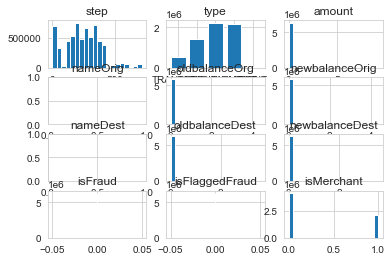

In [22]:
plot_histogram(no_fraud_df)

Es curioso ver como el grueso de transferencias se realizan en las primeras 400 horas (aproximadamente).

Vemos como ninguna de las transferencias lícitas esta marcada en la columna `isFlaggedFraud`, por lo que confirma el hecho de que va a aportar poco al modelo.

Tambien observamos como hay transferencias lícitas tanto a clientes como a comerciantes.

In [23]:
numeric_columns = [x for x in df.columns if df.schema[x].dataType.typeName() != "string"]

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

matrix = Correlation.corr(df_vector, "features")

corr_matrix = matrix.collect()[0][matrix.columns[0]].toArray()

22/05/22 19:38:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/22 19:38:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/opt/anaconda3/envs/tfm/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


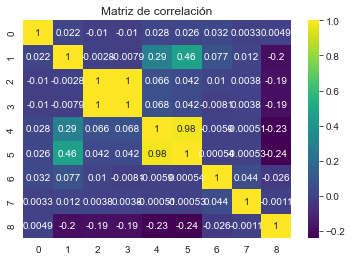

In [24]:
sns.heatmap(corr_matrix, cmap="viridis", annot=True)
plt.title('Matriz de correlación')
plt.show()

De nuestra matriz de correlaciones podemos hacer algunas observaciones:

* Existe una correlación muy fuerte entre la información del saldo inicial y final de las cuentas de los clientes de origen y de destino, lo cual era de esperar. Tal vez esta información sea redundante en nuestro modelo (oldbalanceOrg/newbalanceOrig y oldbalanceDest/newbalanceDest)
* El resto de variables no parecen tener correlaciones relevantes.

# Conclusiones del analisis de datos:

* El dataset esta muy desbalanceado. 6.354.407 de registros lícitos y 8.213 registros fraudulentos. Evidentemente este desbalanceo hay que tenerlo en cuenta en fases posteriores para utilizar las tecnicas del oversampling o subsampling y para utilizar métricas de evaluación del modelo no sensibles a clases desbalanceadas.
* La columna `isFlaggedFraud` se debería eliminar pues hay muy pocos registros que la tengan activa y, por tanto, va a aportar poco al modelo final.
* Existe una correlación muy fuerte entre la información del saldo inicial y final de las cuentas de los clientes de origen y de destino. Sería interesante ver si el modelo mejora el rendimiento eliminando una de ellas.